# Benchmark use case Covid

The notebook is structured as follows:

## Table of contents
1. [Used packages](#import)
1. [Model](#model)    
1. [Data generation](#data)
    1. [Independent variables](#data_indep)
    1. [Dependent variables](#data_dep)
    1. [Suitability of generated data](#data_suit)
1. [Benchmark](#bench)
    1. [Speed and memory consumption](#bench_speed)
    1. [Accuracy](#bench_acc)
1. [Repeated updates](#loop)

## Used packages <a name="import"></a>

In [1]:
import PyPlot as plt
import Seaborn as sns
import Pandas as pd

In [2]:
import Random as rnd
import Distributions as dist

In [3]:
import Turing as tur

In [4]:
import AdvancedPS as aps

In [5]:
import DynamicPPL as ppl

In [6]:
rng = rnd.seed!(123)

MersenneTwister(123)

In [7]:
include("../src/TuringOnline.jl")
using Revise
import .online as online

In [8]:
include("./scoring.jl")
import .scoring as scoring

In [9]:
using StatsFuns: logistic

In [10]:
using BenchmarkTools

In [11]:
using Suppressor

## Model <a name="model"></a>
As a model we use a generalized additive linear model for a poisson-distributed random variable, e.g. cases of a disease in an epidemiological study.

In [12]:
tur.@model matrix_galm_possion(cases,totals::Matrix{Int64}) = begin
    # get time steps
    nt=size(cases,1)
    
    # get locations
    ns=size(cases,2)
 
    # Hyperpriors
    sigma ~ dist.Exponential(1)
    sigmaT ~ dist.Exponential(1)
    sigmaS ~ dist.Exponential(1)
    #sigmaM ~ dist.Exponential(1)
   
    # latent space
    theta0 ~ dist.Normal(0.0,sigma)
    bTime ~ tur.filldist(dist.Normal(0.0,sigmaT), nt,1)
    bSpace ~ tur.filldist(dist.Normal(0.0,sigmaS), 1,ns)        
    #M ~ tur.filldist(dist.Normal(0.0,sigmaM), nt,ns)
        
    theta = logistic.(theta0 .+ bTime .+ bSpace)
    
    # likelihood
    for i = 1:nt
        for j = 1:ns            
            cases[i,j] ~ dist.Poisson(totals[i,j]*theta[i,j])            
        end    
    end
   
    # generated quantities
    return (theta=theta,)
end;

## Generate test data <a name="data"></a>
We generate data synthetically by drawing from the model to rule out modelling errors as a cause for bad inference performance.

### Independent variables <a name="data_indep"></a>

In [13]:
numTimeSteps = 20;

In [14]:
time = range(0; stop=10, length=numTimeSteps)

0.0:0.5263157894736842:10.0

In [15]:
numStates = 5;

In [16]:
totals = fill(100,numTimeSteps,numStates);

### Prior samples for parameters and dependent variable <a name="data_dep"></a>

In [17]:
missing_cases =  fill(missing,(numTimeSteps,numStates));

In [18]:
m_missing_full = matrix_galm_possion(missing_cases,totals)

DynamicPPL.Model{typeof(matrix_galm_possion), (:cases, :totals), (), (), Tuple{Matrix{Missing}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}(:matrix_galm_possion, matrix_galm_possion, (cases = [missing missing … missing missing; missing missing … missing missing; … ; missing missing … missing missing; missing missing … missing missing], totals = [100 100 … 100 100; 100 100 … 100 100; … ; 100 100 … 100 100; 100 100 … 100 100]), NamedTuple(), DynamicPPL.DefaultContext())

In [19]:
prior_chain = tur.sample(m_missing_full, tur.Prior(), 2)

Chains MCMC chain (2×130×1 Array{Float64, 3}):

Iterations        = 1:1:2
Number of chains  = 1
Samples per chain = 2
Wall duration     = 5.2 seconds
Compute duration  = 5.2 seconds
parameters        = sigma, sigmaT, sigmaS, theta0, bTime[1,1], bTime[2,1], bTime[3,1], bTime[4,1], bTime[5,1], bTime[6,1], bTime[7,1], bTime[8,1], bTime[9,1], bTime[10,1], bTime[11,1], bTime[12,1], bTime[13,1], bTime[14,1], bTime[15,1], bTime[16,1], bTime[17,1], bTime[18,1], bTime[19,1], bTime[20,1], bSpace[1,1], bSpace[1,2], bSpace[1,3], bSpace[1,4], bSpace[1,5], cases[1,1], cases[1,2], cases[1,3], cases[1,4], cases[1,5], cases[2,1], cases[2,2], cases[2,3], cases[2,4], cases[2,5], cases[3,1], cases[3,2], cases[3,3], cases[3,4], cases[3,5], cases[4,1], cases[4,2], cases[4,3], cases[4,4], cases[4,5], cases[5,1], cases[5,2], cases[5,3], cases[5,4], cases[5,5], cases[6,1], cases[6,2], cases[6,3], cases[6,4], cases[6,5], cases[7,1], cases[7,2], cases[7,3], cases[7,4], cases[7,5], cases[8,1], cases[8,2], cases[8

In [20]:
generated = tur.generated_quantities(m_missing_full, prior_chain);

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311


In [21]:
thetaTrue = tur.generated_quantities(m_missing_full, prior_chain)[1][:theta];

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311


In [22]:
cases = zeros(Int64,numTimeSteps,numStates)
for i in 1: numTimeSteps
    for j in 1: numStates
        cases[i,j] = prior_chain.value[var=Symbol("cases[$i,$j]")].data[1,1]
    end
end

### Show the data

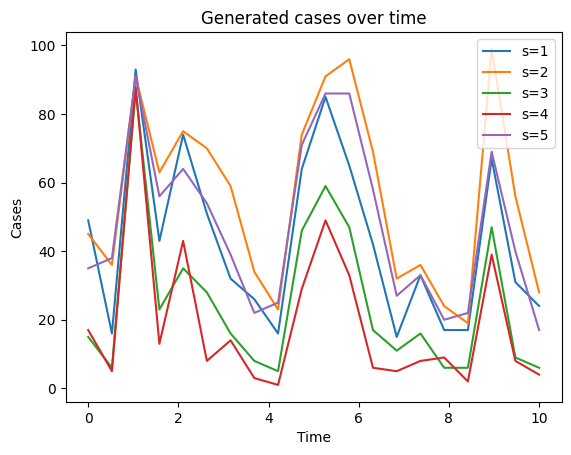

In [23]:
plt.title("Generated cases over time")
for j in 1:numStates
    plt.plot(time,cases[:,j],label="s=$j");
end
plt.legend();
plt.ylabel("Cases");
plt.xlabel("Time");

### Show suitablity by inference through NUTS with full data <a name="data_suit"></a>
We consider the NUTS algorithm as a reference standard and show that the data contains enough information for a meaningful inference.

In [24]:
m_full = matrix_galm_possion(cases,totals);

In [25]:
NUTS = tur.NUTS();

In [26]:
num_chains = 2
num_samples = 1000;

In [27]:
chain_NUTS_full =  tur.sample(m_full, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true);

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


In [28]:
thetaEst = nothing
@suppress begin
    thetaEst = map(x -> x[:theta],tur.generated_quantities(m_missing_full,chain_NUTS_full));
end

1000×2 Matrix{Matrix{Float64}}:
 [0.388212 0.554357 … 0.119252 0.43459; 0.237742 0.379429 … 0.0623979 0.274201; … ; 0.305434 0.462961 … 0.0857831 0.347541; 0.178302 0.298434 … 0.0442523 0.208135]   …  [0.391168 0.537282 … 0.11111 0.444621; 0.246272 0.371267 … 0.0597689 0.289334; … ; 0.372226 0.517275 … 0.103426 0.424896; 0.17808 0.281385 … 0.0404479 0.212582]
 [0.397976 0.543674 … 0.112485 0.480201; 0.19746 0.30721 … 0.0450473 0.255865; … ; 0.316573 0.454993 … 0.0815653 0.392959; 0.176514 0.278664 … 0.0394736 0.230503]       [0.428567 0.583491 … 0.13258 0.500825; 0.251548 0.38567 … 0.0641033 0.31016; … ; 0.337888 0.488027 … 0.0942035 0.405712; 0.215737 0.339423 … 0.0530846 0.269003]
 [0.418555 0.589953 … 0.126444 0.471856; 0.269454 0.424357 … 0.0690449 0.314023; … ; 0.303258 0.465218 … 0.0804763 0.350733; 0.17204 0.293435 … 0.0401059 0.205017]      [0.411151 0.560119 … 0.120652 0.471098; 0.187886 0.296723 … 0.0434857 0.227878; … ; 0.351031 0.496585 … 0.0960791 0.408289; 0.168805 0.2702

In [29]:
thetaEstMean = dist.mean(thetaEst);

In [30]:
thetaEstStd = dist.std(thetaEst);

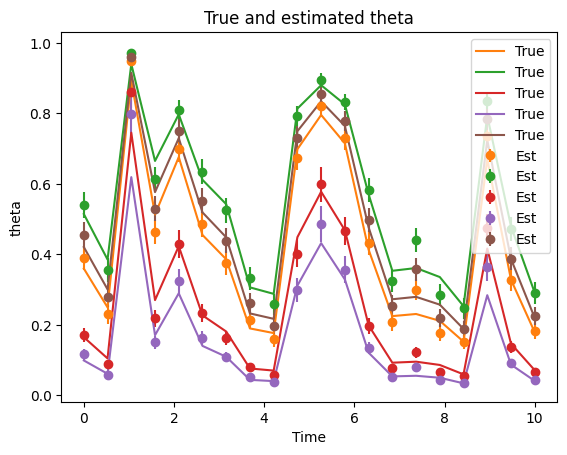

In [31]:
plt.title("True and estimated theta")
for j in 1:numStates
  plt.plot(time,thetaTrue[:,j],label="True",color="C$j");
  plt.errorbar(x=time,y=thetaEstMean[:,j],yerr=thetaEstStd[:,j],fmt="o",color="C$j",label="Est")
end
plt.legend();
plt.ylabel("theta")
plt.xlabel("Time");

In [32]:
thetaList = vec([ Symbol("theta[$i,$j]") for i = 1:size(thetaTrue,1), j = 1:size(thetaTrue,2)]);

In [33]:
trueVals = Dict((Symbol("theta[$i,$j]"),thetaTrue[i,j]) for i = 1:size(thetaTrue,1), j = 1:size(thetaTrue,2));

In [34]:
paramsList = [:sigma, :sigmaT, :sigmaS, :theta0]

4-element Vector{Symbol}:
 :sigma
 :sigmaT
 :sigmaS
 :theta0

In [35]:
trueVals = Dict((p,prior_chain[1][p][1]) for p in paramsList)

Dict{Symbol, Float64} with 4 entries:
  :sigmaT => 1.95747
  :theta0 => 0.0582961
  :sigmaS => 0.508933
  :sigma  => 0.126892

In [36]:
scoring.getScore(chain_NUTS_full,paramsList,trueVals)

-4.086173110715553

## Benchmark of updating <a name="bench"></a>
We consider the situation where data and inferred parameters up to a point t in time are available and new data arrives at time t+1.

In [37]:
someTime = length(time)-1

19

In [38]:
cases_t =  cases[1:someTime,:]

19×5 Matrix{Int64}:
 49  45  15  17  35
 16  36   6   5  38
 93  91  87  88  91
 43  63  23  13  56
 74  75  35  43  64
 51  70  28   8  54
 32  59  16  14  39
 26  34   8   3  22
 16  23   5   1  25
 64  74  46  29  71
 85  91  59  49  86
 65  96  47  33  86
 42  69  17   6  58
 15  32  11   5  27
 33  36  16   8  33
 17  24   6   9  20
 17  19   6   2  22
 67  99  47  39  69
 31  56   9   8  40

In [39]:
cases_t_inc = cases[1:someTime+1,:]

20×5 Matrix{Int64}:
 49  45  15  17  35
 16  36   6   5  38
 93  91  87  88  91
 43  63  23  13  56
 74  75  35  43  64
 51  70  28   8  54
 32  59  16  14  39
 26  34   8   3  22
 16  23   5   1  25
 64  74  46  29  71
 85  91  59  49  86
 65  96  47  33  86
 42  69  17   6  58
 15  32  11   5  27
 33  36  16   8  33
 17  24   6   9  20
 17  19   6   2  22
 67  99  47  39  69
 31  56   9   8  40
 24  28   6   4  17

In [40]:
model_t = matrix_galm_possion(cases_t,totals)

DynamicPPL.Model{typeof(matrix_galm_possion), (:cases, :totals), (), (), Tuple{Matrix{Int64}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}(:matrix_galm_possion, matrix_galm_possion, (cases = [49 45 … 17 35; 16 36 … 5 38; … ; 67 99 … 39 69; 31 56 … 8 40], totals = [100 100 … 100 100; 100 100 … 100 100; … ; 100 100 … 100 100; 100 100 … 100 100]), NamedTuple(), DynamicPPL.DefaultContext())

In [41]:
model_t_inc = matrix_galm_possion(cases_t_inc,totals)

DynamicPPL.Model{typeof(matrix_galm_possion), (:cases, :totals), (), (), Tuple{Matrix{Int64}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}(:matrix_galm_possion, matrix_galm_possion, (cases = [49 45 … 17 35; 16 36 … 5 38; … ; 31 56 … 8 40; 24 28 … 4 17], totals = [100 100 … 100 100; 100 100 … 100 100; … ; 100 100 … 100 100; 100 100 … 100 100]), NamedTuple(), DynamicPPL.DefaultContext())

#### Get a chain from nuts
We assume here that the parameter set up to time t is also available, we use NUTS as a reference for that:

In [42]:
chain_t = tur.sample(model_t, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Chains MCMC chain (1000×40×2 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 2
Samples per chain = 1000
Wall duration     = 8.3 seconds
Compute duration  = 16.37 seconds
parameters        = sigma, sigmaT, sigmaS, theta0, bTime[1,1], bTime[2,1], bTime[3,1], bTime[4,1], bTime[5,1], bTime[6,1], bTime[7,1], bTime[8,1], bTime[9,1], bTime[10,1], bTime[11,1], bTime[12,1], bTime[13,1], bTime[14,1], bTime[15,1], bTime[16,1], bTime[17,1], bTime[18,1], bTime[19,1], bSpace[1,1], bSpace[1,2], bSpace[1,3], bSpace[1,4], bSpace[1,5]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
   parameters      mean       std   naive_se      mcse        ess      rhat    ⋯
       Symbol   Float64   Float64    Float64   Float64    Float64   Float64    ⋯

        sigma    0.7136    0.6858     0.0153    0.0226   655.1687 

### Speed and memory consumption <a name="bench_speed"></a>

In [43]:
@benchmark online.update(chain_t,model_t_inc,tur.SMC(),rng) seconds = 60

Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[

BenchmarkTools.Trial: 18 samples with 1 evaluation.
 Range (min … max):  3.078 s …    3.881 s  ┊ GC (min … max): 13.16% … 22.45%
 Time  (median):     3.359 s               ┊ GC (median):    16.85%
 Time  (mean ± σ):   3.396 s ± 259.000 ms  ┊ GC (mean ± σ):  18.25% ±  4.76%

  █▁ █      ▁      █ ▁█       ▁▁     ▁        ▁    ▁ ▁     ▁  
  ██▁█▁▁▁▁▁▁█▁▁▁▁▁▁█▁██▁▁▁▁▁▁▁██▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁█▁█▁▁▁▁▁█ ▁
  3.08 s         Histogram: frequency by time         3.88 s <

 Memory estimate: 3.03 GiB, allocs estimate: 10734568.

In [44]:
@benchmark tur.sample(model_t_inc, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true) seconds = 60

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  6.535 s …    8.520 s  ┊ GC (min … max): 16.81% … 16.51%
 Time  (median):     7.061 s               ┊ GC (median):    15.56%
 Time  (mean ± σ):   7.165 s ± 595.118 ms  ┊ GC (mean ± σ):  15.63% ±  1.03%

  █  █ █      █  █     █ █ █                               █  
  █▁▁█▁█▁▁▁▁▁▁█▁▁█▁▁▁▁▁█▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  6.53 s         Histogram: frequency by time         8.52 s <

 Memory estimate: 8.44 GiB, allocs estimate: 15587927.

### Accuracy <a name="bench_acc"></a>
We compare the estimated values from the online update and from NUTS to the true values.

In [45]:
newChain = online.update(chain_t,model_t_inc,tur.SMC(),rng);

Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.


In [46]:
scoring.getScore(newChain,paramsList,trueVals)

-5.418261743292096

In [47]:
for x in 1:5
    newChain = online.update(chain_t,model_t_inc,tur.SMC(),rng);
    print(scoring.getScore(newChain,paramsList,trueVals))
end

Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
-31.087226330403034Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
-4.703097889820192Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
0.9275174392951548Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
-5.2383753840405465Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
-5.823940327422919

In [48]:
chain_t_inc = tur.sample(model_t_inc, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true);

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


In [49]:
scoring.getScore(chain_t_inc,paramsList,trueVals)

-3.5961340374617956

In [50]:
for x in 1:5
    chain_t_inc = tur.sample(model_t_inc, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true);
    print(scoring.getScore(chain_t_inc,paramsList,trueVals))
end

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


-5.313929014218063

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


-3.5216226790934444

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


-2.3589929643182073

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


-3.444781214865781

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


-1.5827123608023692

In [51]:
dictChains = Dict("Update" => newChain, "NUTS" => chain_t_inc , "True" => prior_chain);

In [52]:
dictColor = Dict("Update" => "C1", "NUTS" => "C2" , "True" => "k");

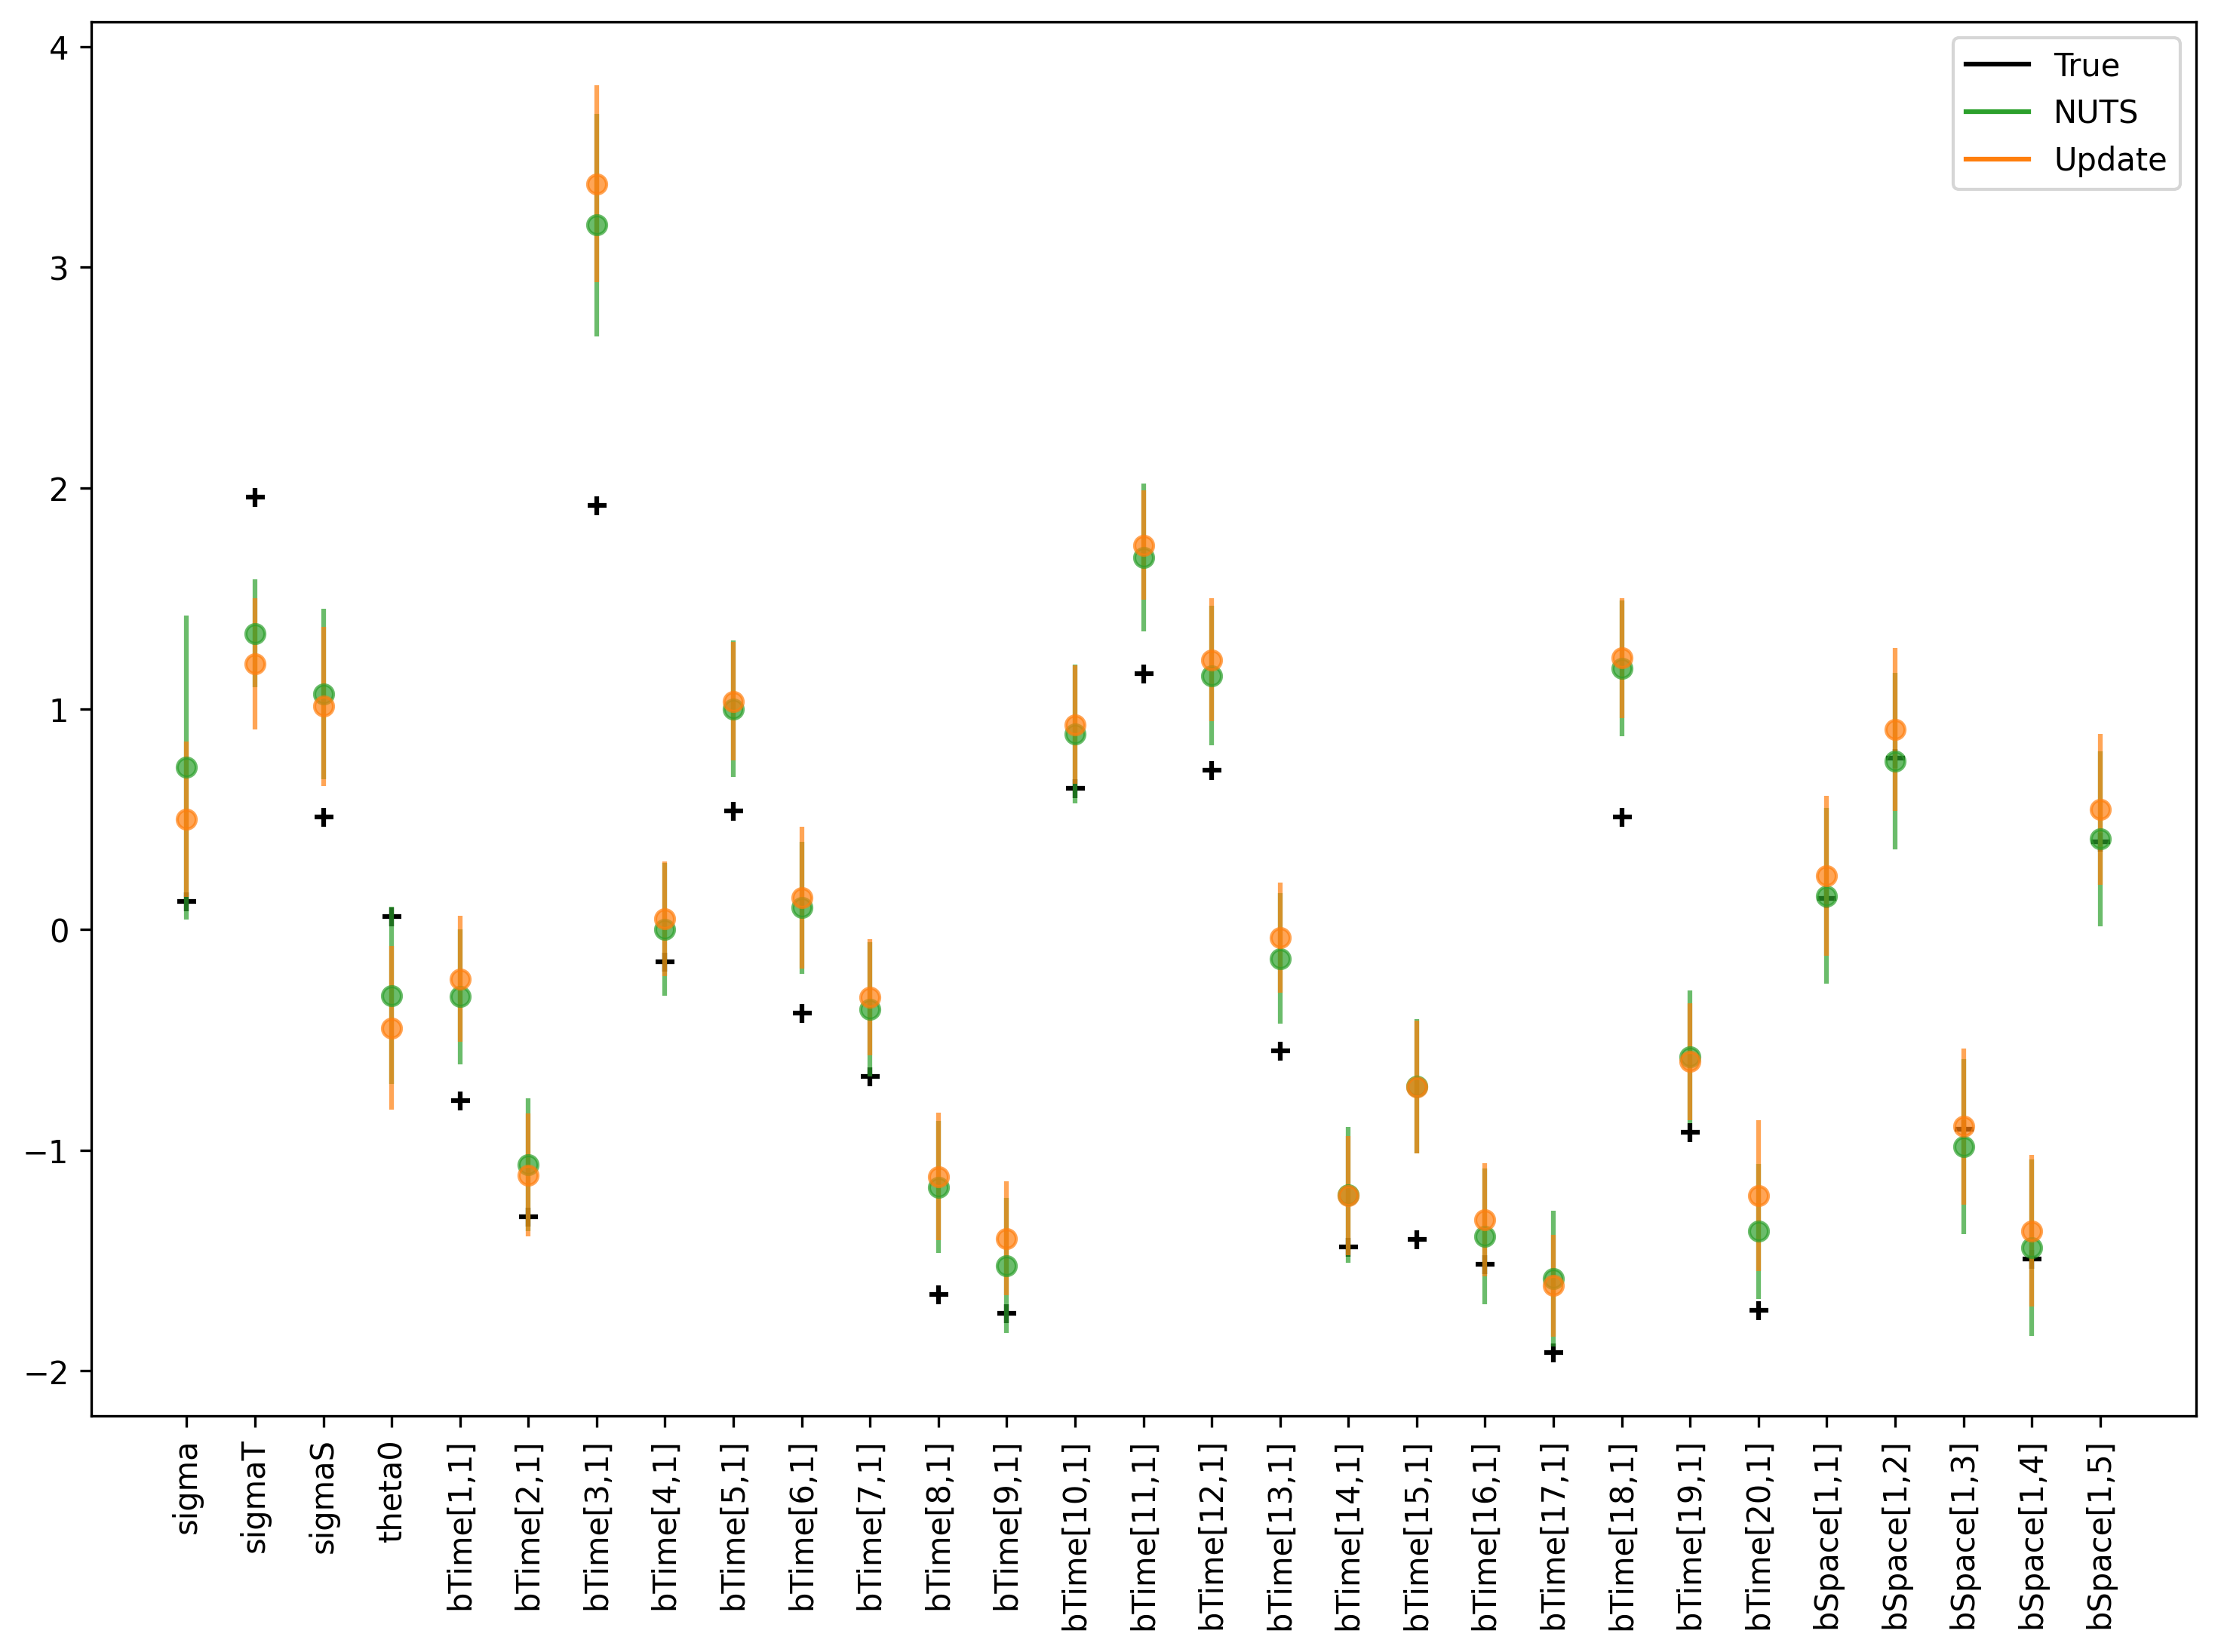

In [53]:
plt.figure(figsize=(12,8),dpi=300)
for (i,sym) in enumerate(chain_t_inc.name_map.parameters)
    for (k,v) in dictChains
        if sym in v.name_map.parameters
            if k != "True"
                # compute statistics
                samples = collect(Iterators.flatten(v[sym].data))
                mean = dist.mean(samples)
                std = dist.std(samples)
                
                # plot errorbars
                plt.errorbar(x=i,y=mean,yerr=std,fmt="o",color=dictColor[k],alpha=0.7)
            else 
                # plot true
                plt.scatter([i],v[sym].data[1,:],color="k",marker="+")
            end
        end        
    
    end
end
# add labels
for (ckey,cvalue) in dictColor
    plt.plot([],[],label=ckey,color=cvalue)
end
plt.legend()

# ticks
plt.xticks(1:length(chain_t_inc.name_map.parameters), chain_t_inc.name_map.parameters, rotation="vertical")

plt.show()

## Repeated updates <a name="loop"></a>
We investigate the repeated use of the online update over a time series.

In [54]:
chainDict = Dict()

Dict{Any, Any}()

In [55]:
smc = tur.SMC()

Turing.Inference.SMC{(), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}(AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}(AdvancedPS.resample_systematic, 0.5))

In [56]:
for (i,t) in enumerate(time)
   
    # set up model
    model_t = matrix_galm_possion(cases[1:i,:],totals)
    
    if i == 1
        println("NUTS at $i")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    elseif i ==2
        println("NUTS at $i")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("Online at $i")
        chainDict[(i,"Online")] = online.update(chainDict[(i-1,"NUTS")],model_t,tur.SMC(),rng)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    else
        println("NUTS at $i.")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("Online at $i")
        chainDict[(i,"Online")] = online.update(chainDict[(i-1,"Online")],model_t,tur.SMC(),rng)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    end
end

NUTS at 1


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


SMC at 1
NUTS at 2


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 2
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[2,1]")]) 
Using prior samples from the model for them instead.
SMC at 2
NUTS at 3.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 3
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[3,1]")]) 
Using prior samples from the model for them instead.
SMC at 3
NUTS at 4.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 4
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[4,1]")]) 
Using prior samples from the model for them instead.
SMC at 4
NUTS at 5.


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 5
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[5,1]")]) 
Using prior samples from the model for them instead.
SMC at 5
NUTS at 6.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 6
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[6,1]")]) 
Using prior samples from the model for them instead.
SMC at 6
NUTS at 7.


┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 7
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[7,1]")]) 
Using prior samples from the model for them instead.
SMC at 7
NUTS at 8.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 8
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[8,1]")]) 
Using prior samples from the model for them instead.
SMC at 8
NUTS at 9.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 9
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[9,1]")]) 
Using prior samples from the model for them instead.
SMC at 9
NUTS at 10.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 10
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[10,1]")]) 
Using prior samples from the model for them instead.
SMC at 10
NUTS at 11.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 11
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[11,1]")]) 
Using prior samples from the model for them instead.
SMC at 11
NUTS at 12.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 12
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[12,1]")]) 
Using prior samples from the model for them instead.
SMC at 12
NUTS at 13.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 13
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[13,1]")]) 
Using prior samples from the model for them instead.
SMC at 13
NUTS at 14.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 14
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[14,1]")]) 
Using prior samples from the model for them instead.
SMC at 14
NUTS at 15.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 15
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[15,1]")]) 
Using prior samples from the model for them instead.
SMC at 15
NUTS at 16.


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 16
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[16,1]")]) 
Using prior samples from the model for them instead.
SMC at 16
NUTS at 17.


┌ Info: Found initial step size
│   ϵ = 0.025390625
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 17
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[17,1]")]) 
Using prior samples from the model for them instead.
SMC at 17
NUTS at 18.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 18
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[18,1]")]) 
Using prior samples from the model for them instead.
SMC at 18
NUTS at 19.


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 19
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[19,1]")]) 
Using prior samples from the model for them instead.
SMC at 19
NUTS at 20.


┌ Info: Found initial step size
│   ϵ = 0.010937500000000001
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 20
Some parameters in are not present in the chain but in the model: Set(Any[Symbol("bTime[20,1]")]) 
Using prior samples from the model for them instead.
SMC at 20


### Analysis

In [57]:
chainDict

Dict{Any, Any} with 59 entries:
  (15, "SMC")    => MCMC chain (100×26×2 Array{Float64, 3})
  (11, "NUTS")   => MCMC chain (100×32×2 Array{Float64, 3})
  (14, "Online") => MCMC chain (100×25×2 Array{Float64, 3})
  (3, "Online")  => MCMC chain (100×14×2 Array{Float64, 3})
  (5, "SMC")     => MCMC chain (100×16×2 Array{Float64, 3})
  (7, "NUTS")    => MCMC chain (100×28×2 Array{Float64, 3})
  (6, "SMC")     => MCMC chain (100×17×2 Array{Float64, 3})
  (15, "Online") => MCMC chain (100×26×2 Array{Float64, 3})
  (2, "NUTS")    => MCMC chain (100×23×2 Array{Float64, 3})
  (10, "NUTS")   => MCMC chain (100×31×2 Array{Float64, 3})
  (18, "NUTS")   => MCMC chain (100×39×2 Array{Float64, 3})
  (5, "Online")  => MCMC chain (100×16×2 Array{Float64, 3})
  (16, "NUTS")   => MCMC chain (100×37×2 Array{Float64, 3})
  (20, "NUTS")   => MCMC chain (100×41×2 Array{Float64, 3})
  (19, "NUTS")   => MCMC chain (100×40×2 Array{Float64, 3})
  (13, "SMC")    => MCMC chain (100×24×2 Array{Float64, 3})
  (4, "S

In [58]:
function plotEstimates(chainDict,name,prior_chain)
    # time indices
    times = sort(unique([t for (t,m) in keys(chainDict)]))
    
    colorDict = Dict("NUTS" => "C0","Online" => "C1","SMC" => "C2")
    jitter = 0.09
    jitterDict = Dict("NUTS" => -jitter,"Online" => 0.0,"SMC" => jitter)
    
    methods = ["NUTS","Online","SMC"]
    
    # extract values
    for method in methods
        for t in times
            key = (t,method)           
            if haskey(chainDict, key) && Symbol(name) in chainDict[key].name_map.parameters
                samples = collect(Iterators.flatten(chainDict[key][Symbol(name)].data))                
                mean = dist.mean(samples)
                std = dist.std(samples)
                
                # pseudo x with jitter
                x = t
                x += jitterDict[method]

                # plot errorbars
                plt.errorbar(x=x,y=mean,yerr=std,fmt="o",color=colorDict[method])
            end
        end    
    end

    # Add legend
    for method in methods
       plt.plot([],[],color=colorDict[method],label=method) 
    end    
    
    # Show true value
    trueVal = prior_chain[Symbol(name)].data[1,1]
    plt.plot(times,trueVal.*ones(length(times)),color="k",label="True")
    plt.legend()
    
    # set labels
    plt.ylabel(name)
    plt.xlabel("Timestep")
    
    return nothing
end    

plotEstimates (generic function with 1 method)

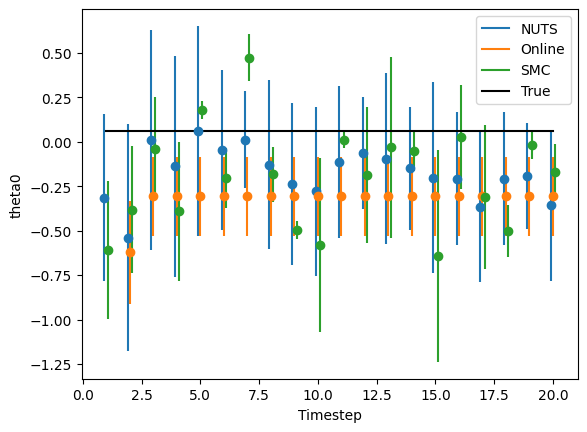

In [59]:
plotEstimates(chainDict,"theta0",prior_chain)

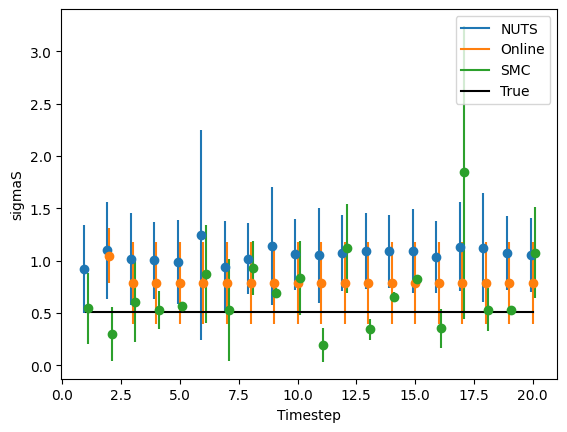

In [60]:
plotEstimates(chainDict,"sigmaS",prior_chain)

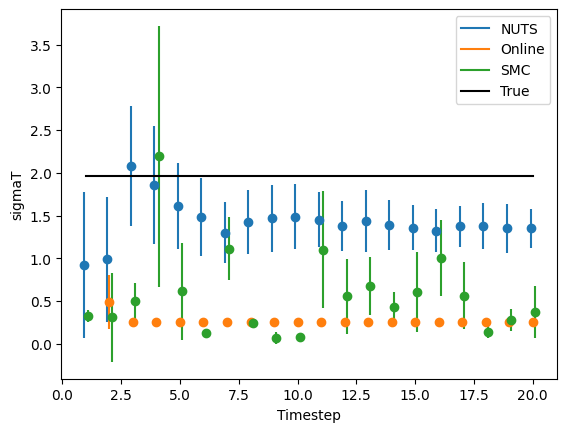

In [61]:
plotEstimates(chainDict,"sigmaT",prior_chain)

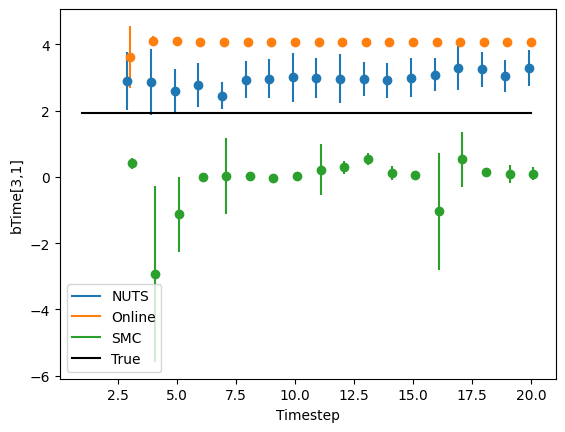

In [62]:
plotEstimates(chainDict,"bTime[3,1]",prior_chain)

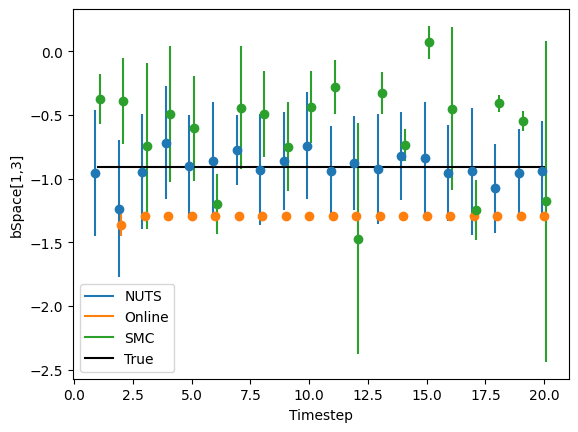

In [63]:
plotEstimates(chainDict,"bSpace[1,3]",prior_chain)

In [66]:
function plotScores(chainDict,params,trueVals)
    # time indices
    times = sort(unique([t for (t,m) in keys(chainDict)]))
    
    colorDict = Dict("NUTS" => "C0","Online" => "C1","SMC" => "C2")
    jitter = 0.09
    jitterDict = Dict("NUTS" => -jitter,"Online" => 0.0,"SMC" => jitter)
    
    methods = ["NUTS","Online","SMC"]
    
    # extract values
    for method in methods
        for t in times
            key = (t,method)           
            if haskey(chainDict, key) 
                try
                    chain = chainDict[key]
                    score = scoring.getScore(chain,params,trueVals)

                    # pseudo x with jitter
                    x = t
                    x += jitterDict[method]

                    # plot errorbars
                    plt.errorbar(x=x,y=score,fmt="o",color=colorDict[method])
                catch e
                    print(e)
                end
            end
        end    
    end

    # Add legend
    for method in methods
       plt.plot([],[],color=colorDict[method],label=method) 
    end  
    plt.legend()
    
    # set labels
    plt.ylabel("Score")
    plt.xlabel("Timestep")
    
    return nothing
end

plotScores (generic function with 1 method)

DomainError(-1.399385151743575e-33, 

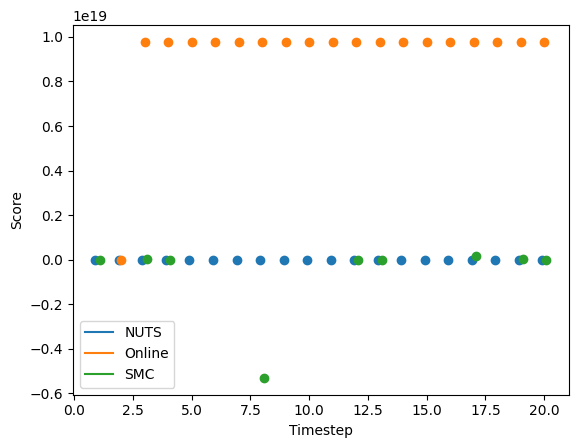

"log will only return a complex result if called with a complex argument. Try log(Complex(x)).")DomainError(-3.9034347149247385e-53, "log will only return a complex result if called with a complex argument. Try log(Complex(x)).")DomainError(-1.9689517090001403e-37, "log will only return a complex result if called with a complex argument. Try log(Complex(x)).")DomainError(-2.869752598075352e-47, "log will only return a complex result if called with a complex argument. Try log(Complex(x)).")DomainError(-3.4662122216483757e-37, "log will only return a complex result if called with a complex argument. Try log(Complex(x)).")DomainError(-3.1504512293091803e-51, "log will only return a complex result if called with a complex argument. Try log(Complex(x)).")DomainError(-1.4500802116297343e-37, "log will only return a complex result if called with a complex argument. Try log(Complex(x)).")DomainError(-2.8354229976683575e-51, "log will only return a complex result if called with a complex argume

In [67]:
plotScores(chainDict,paramsList,trueVals)